In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N

In [6]:
# Preprocessing der Rohdaten: 100%
ZR_100new=np.atleast_2d(ZR_N100)
if ZR_100new.shape[0]==1:
    ZR_100new=ZR_100new.T
nb_samples_100, nb_series_100 = ZR_100new.shape

In [7]:
# Einteilung in Trainings- und Testdaten:normalisierte Daten
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_N100[:-test_size_100], ZR_N100[-test_size_100:] 

In [8]:
# Einteilung in Trainings- und Testdaten:originale Daten
train_100_O, test_100_O = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

In [9]:
# Shape des Input und Outputs anpassen: 100%
look_forward=240
window_size=12
# Trainingsdaten
Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=train_100[window_size+look_forward:]
qtrain_100=np.atleast_3d([train_100[-(window_size):]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

# Testdaten
Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=test_100[window_size+look_forward:]
qtest_100=np.atleast_3d([test_100[-(window_size):]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (353, 1) (353, 12, 1)
(1, 12, 1) (6, 1) (6, 12, 1)


In [10]:
ytrain_100_O=train_100_O[window_size+look_forward:]
ytest_100_O=test_100_O[window_size+look_forward:]

In [11]:
# Modell zusammenbauen: 
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='sigmoid', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='sigmoid'))
model.add(MaxPooling1D())
model.add(Convolution1D(nb_filter=nb_filter_3, filter_length=filter_length, activation='sigmoid'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(nb_outputs, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mae']) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="sigmoid", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="sigmoid", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="sigmoid", filters=64, kernel_size=2)`
  del sys.path[0]


In [12]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

In [13]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [14]:
# Modellanpassen: 100%
history_reg=model.fit(Xtrain_100, ytrain_100, epochs=200, batch_size=25, validation_data=(Xtest_100, ytest_100))

Train on 353 samples, validate on 6 samples
Epoch 1/200
353/353 [==============================] - 3s 8ms/step - loss: 0.1868 - mean_absolute_error: 0.3451 - val_loss: 0.0239 - val_mean_absolute_error: 0.1446
Epoch 2/200
353/353 [==============================] - 0s 334us/step - loss: 0.1367 - mean_absolute_error: 0.2863 - val_loss: 0.0042 - val_mean_absolute_error: 0.0496
Epoch 3/200
353/353 [==============================] - 0s 327us/step - loss: 0.1047 - mean_absolute_error: 0.2506 - val_loss: 0.0039 - val_mean_absolute_error: 0.0480
Epoch 4/200
353/353 [==============================] - 0s 373us/step - loss: 0.0809 - mean_absolute_error: 0.2256 - val_loss: 0.0032 - val_mean_absolute_error: 0.0459
Epoch 5/200
353/353 [==============================] - 0s 336us/step - loss: 0.0650 - mean_absolute_error: 0.1977 - val_loss: 0.0054 - val_mean_absolute_error: 0.0540
Epoch 6/200
353/353 [==============================] - 0s 315us/step - loss: 0.0540 - mean_absolute_error: 0.1790 - val_los

353/353 [==============================] - 0s 398us/step - loss: 0.0241 - mean_absolute_error: 0.1090 - val_loss: 0.0104 - val_mean_absolute_error: 0.0857
Epoch 50/200
353/353 [==============================] - 0s 339us/step - loss: 0.0238 - mean_absolute_error: 0.1145 - val_loss: 0.0090 - val_mean_absolute_error: 0.0772
Epoch 51/200
353/353 [==============================] - 0s 303us/step - loss: 0.0232 - mean_absolute_error: 0.1024 - val_loss: 0.0125 - val_mean_absolute_error: 0.0973
Epoch 52/200
353/353 [==============================] - 0s 360us/step - loss: 0.0239 - mean_absolute_error: 0.1188 - val_loss: 0.0069 - val_mean_absolute_error: 0.0626
Epoch 53/200
353/353 [==============================] - 0s 397us/step - loss: 0.0239 - mean_absolute_error: 0.1039 - val_loss: 0.0126 - val_mean_absolute_error: 0.0978
Epoch 54/200
353/353 [==============================] - 0s 304us/step - loss: 0.0233 - mean_absolute_error: 0.1090 - val_loss: 0.0115 - val_mean_absolute_error: 0.0922
Epoch

353/353 [==============================] - 0s 333us/step - loss: 0.0224 - mean_absolute_error: 0.1070 - val_loss: 0.0119 - val_mean_absolute_error: 0.0944
Epoch 98/200
353/353 [==============================] - 0s 351us/step - loss: 0.0213 - mean_absolute_error: 0.1044 - val_loss: 0.0118 - val_mean_absolute_error: 0.0936
Epoch 99/200
353/353 [==============================] - 0s 300us/step - loss: 0.0227 - mean_absolute_error: 0.1079 - val_loss: 0.0111 - val_mean_absolute_error: 0.0900
Epoch 100/200
353/353 [==============================] - 0s 308us/step - loss: 0.0231 - mean_absolute_error: 0.1158 - val_loss: 0.0092 - val_mean_absolute_error: 0.0790
Epoch 101/200
353/353 [==============================] - 0s 323us/step - loss: 0.0239 - mean_absolute_error: 0.1019 - val_loss: 0.0111 - val_mean_absolute_error: 0.0901
Epoch 102/200
353/353 [==============================] - 0s 338us/step - loss: 0.0226 - mean_absolute_error: 0.1134 - val_loss: 0.0099 - val_mean_absolute_error: 0.0833
Ep

353/353 [==============================] - 0s 370us/step - loss: 0.0230 - mean_absolute_error: 0.1144 - val_loss: 0.0108 - val_mean_absolute_error: 0.0881
Epoch 146/200
353/353 [==============================] - 0s 343us/step - loss: 0.0225 - mean_absolute_error: 0.1040 - val_loss: 0.0100 - val_mean_absolute_error: 0.0834
Epoch 147/200
353/353 [==============================] - 0s 364us/step - loss: 0.0226 - mean_absolute_error: 0.1072 - val_loss: 0.0115 - val_mean_absolute_error: 0.0924
Epoch 148/200
353/353 [==============================] - 0s 332us/step - loss: 0.0221 - mean_absolute_error: 0.1085 - val_loss: 0.0117 - val_mean_absolute_error: 0.0933
Epoch 149/200
353/353 [==============================] - 0s 457us/step - loss: 0.0221 - mean_absolute_error: 0.1069 - val_loss: 0.0106 - val_mean_absolute_error: 0.0872
Epoch 150/200
353/353 [==============================] - 0s 299us/step - loss: 0.0220 - mean_absolute_error: 0.1046 - val_loss: 0.0121 - val_mean_absolute_error: 0.0953


353/353 [==============================] - 0s 342us/step - loss: 0.0226 - mean_absolute_error: 0.1019 - val_loss: 0.0101 - val_mean_absolute_error: 0.0841
Epoch 194/200
353/353 [==============================] - 0s 350us/step - loss: 0.0227 - mean_absolute_error: 0.1128 - val_loss: 0.0105 - val_mean_absolute_error: 0.0868
Epoch 195/200
353/353 [==============================] - 0s 369us/step - loss: 0.0224 - mean_absolute_error: 0.1020 - val_loss: 0.0109 - val_mean_absolute_error: 0.0889
Epoch 196/200
353/353 [==============================] - 0s 323us/step - loss: 0.0225 - mean_absolute_error: 0.1135 - val_loss: 0.0115 - val_mean_absolute_error: 0.0921
Epoch 197/200
353/353 [==============================] - 0s 330us/step - loss: 0.0220 - mean_absolute_error: 0.1026 - val_loss: 0.0105 - val_mean_absolute_error: 0.0866
Epoch 198/200
353/353 [==============================] - 0s 294us/step - loss: 0.0222 - mean_absolute_error: 0.1098 - val_loss: 0.0112 - val_mean_absolute_error: 0.0906


Text(0.5,1,'Loss Curves')

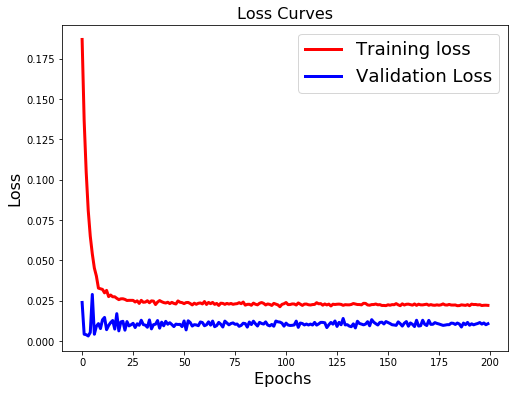

In [15]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['loss'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

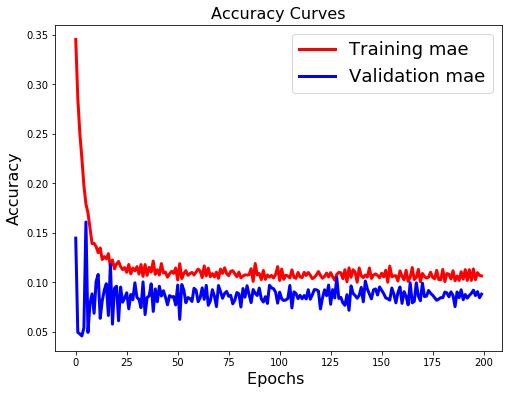

In [16]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_reg.history['mean_absolute_error'],'r',linewidth=3.0)
plt.plot(history_reg.history['val_mean_absolute_error'],'b',linewidth=3.0)
plt.legend(['Training mae', 'Validation mae'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [17]:
# Vorhersage generieren
predictions_100N = model.predict(Xtest_100)
predictions_train_100N=model.predict(Xtrain_100)

# Prediction Denormalizing
testPredict_100=scaler.inverse_transform(predictions_100N)
trainPredict_100=scaler.inverse_transform(predictions_train_100N)

In [18]:
# Modellperformance bewerten
mse = mean_squared_error(ytest_100_O, testPredict_100)
print('Test MSE: %.3f' % mse)

mse_train = mean_squared_error(ytrain_100_O, trainPredict_100)
print('Train MSE: %.3f' % mse_train)

Test MSE: 63327596.844
Train MSE: 128707628.261


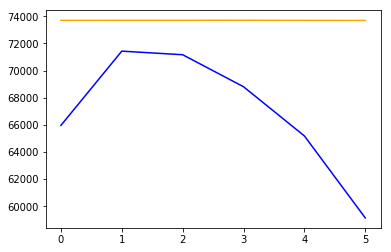

In [19]:
# Gegenüberstellung von Vorhersage und originalen Daten
plt.plot(ytest_100_O, color='blue') 
plt.plot(testPredict_100, color='orange') 
plt.show()

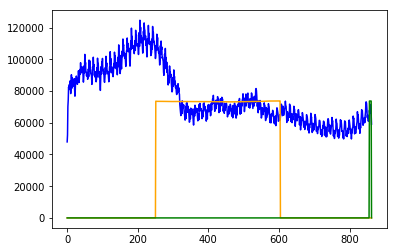

In [20]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
trainPredictPlot = trainPredictPlot.reshape(len(ZR_100),1)
trainPredictPlot[(window_size+look_forward-1):len(trainPredict_100)+(window_size+look_forward-1)] = trainPredict_100


# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
testPredictPlot = testPredictPlot.reshape(len(ZR_100),1)
testPredictPlot[len(trainPredict_100)+2*(window_size+look_forward)-1:len(ZR_100)-1] = testPredict_100
     
       
# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()